In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import normalize

# Function to Find the Heidke Score from Confusion Matrix

In [2]:
def findHeidkeScore(confMat):
    TP = confMat[1][1]
    TN = confMat[0][0]
    FN = confMat[1][0]
    FP = confMat[0][1]
    HSS = 2.*((TP*TN) - (FN*FP))/((TP + FN)*(FN + TN) + (TP + FP)*(FP + TN)) # Heidke Skill Score
    #TSS = (TP/(TP + FN)) - (FP/(FP + TN)) # True Skill Score
    #BIAS = (TP + FP)/(TP + FN) # Bias of Detection
    #POD = TP/(TP + FN) # Probability of Detection
    #POFD = FP/(TN + FP) # Probablity of False Detection
    #FAR = FP/(TP + FP) # False Alarm Ratio
    #TS = TP/(TP + FN + FP) # Threat Score
    #OR = (TP*TN)/(FN*FP) # Odds Ratio
    return HSS

def findThreatScore(confMat):
    #How well did the forecast "yes" events correspond to the observed "yes" events?
    TP = confMat[1][1]
    TN = confMat[0][0]
    FN = confMat[1][0]
    FP = confMat[0][1]
    TS = (TP/(TP + FN)) - (FP/(FP + TN))
    return TS

In [3]:
#=====Data Reading=====#
# Identify the directory path of this python program
#dir_path = os.path.dirname(os.path.realpath(__file__))

# Read in a csv to pandas dataframe
df = pd.read_csv('ionosphere.data', header = None)

In [4]:
print(df.head(2))

   0   1        2        3        4        5        6        7    8        9   \
0   1   0  0.99539 -0.05889  0.85243  0.02306  0.83398 -0.37708  1.0  0.03760   
1   1   0  1.00000 -0.18829  0.93035 -0.36156 -0.10868 -0.93597  1.0 -0.04549   

   ...       25       26       27       28       29       30       31  \
0  ... -0.51171  0.41078 -0.46168  0.21266 -0.34090  0.42267 -0.54487   
1  ... -0.26569 -0.20468 -0.18401 -0.19040 -0.11593 -0.16626 -0.06288   

        32       33  34  
0  0.18641 -0.45300   g  
1 -0.13738 -0.02447   b  

[2 rows x 35 columns]


In [5]:
#=====Data Processing=====#
# Recategorize the classification labels into a binary classifier
categ = {"g" : 1, "b" : 0}
df[34] = [categ[item] for item in df[34]]

In [6]:
print(df.head(2))

   0   1        2        3        4        5        6        7    8        9   \
0   1   0  0.99539 -0.05889  0.85243  0.02306  0.83398 -0.37708  1.0  0.03760   
1   1   0  1.00000 -0.18829  0.93035 -0.36156 -0.10868 -0.93597  1.0 -0.04549   

   ...       25       26       27       28       29       30       31  \
0  ... -0.51171  0.41078 -0.46168  0.21266 -0.34090  0.42267 -0.54487   
1  ... -0.26569 -0.20468 -0.18401 -0.19040 -0.11593 -0.16626 -0.06288   

        32       33  34  
0  0.18641 -0.45300   1  
1 -0.13738 -0.02447   0  

[2 rows x 35 columns]


In [ ]:
print(df.iloc[0:350,0:33])

# Spliting the Data Set

In [7]:
# Seperate inputs and outputs
labels = df[34]
inputs = df.drop([34],axis=1)

# Seperate data into a training/test set
input_train, input_test, output_train, output_test = train_test_split(inputs, 
                                                                      labels, test_size=0.33, 
                                                                      random_state=42)



print("Before OverSampling, counts of label '1': {}".format(sum(output_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(output_train==0)))

Before OverSampling, counts of label '1': 154
Before OverSampling, counts of label '0': 81 



# SVC Without PCA

## SVC on the Original DataSet -- Without Resample

In [11]:
from sklearn.svm import SVC
modelOriginal = SVC()
histOriginal = modelOriginal.fit(input_train,output_train)
predictionsOriginal = modelOriginal.predict(input_test)
confMatSVCOriginal = confusion_matrix(output_test,predictionsOriginal)
print(confMatSVCOriginal)

[[38  7]
 [ 0 71]]


## SVC on the Resampled DataSet

In [12]:
sm = SMOTE(random_state = 27, sampling_strategy = 1.0)
input_train_res,output_train_res = sm.fit_resample(input_train,output_train)
print("After OverSampling, counts of label '1': {}".format(sum(output_train_res==1)))
print("After OverSampling, counts of label '0': {} \n".format(sum(output_train_res==0)))
modelResample = SVC()
histResample = modelResample.fit(input_train_res,output_train_res)
predictionsResample = modelResample.predict(input_test)
confMatSVCResample = confusion_matrix(output_test,predictionsResample)
print(confMatSVCResample)

After OverSampling, counts of label '1': 154
After OverSampling, counts of label '0': 154 

[[41  4]
 [ 0 71]]


# Introducing PCA

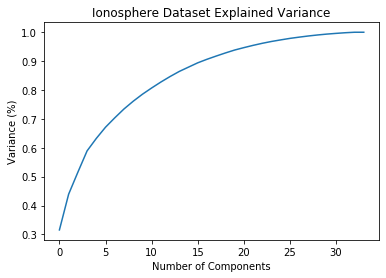

(235, 34)
(235, 17)


In [13]:
#Dimentioanlity reduction
from sklearn.decomposition import PCA
pca = PCA() 

input_train = pca.fit_transform(input_train)
input_test = pca.transform(input_test)
total=sum(pca.explained_variance_)

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Ionosphere Dataset Explained Variance')
plt.show()

k=0
current_variance=0
while current_variance/total < 0.90:
    current_variance += pca.explained_variance_[k]
    k=k+1

#Apply PCA with n_components
pca = PCA(n_components=k)

print(input_train.shape)
input_train_PCA = pca.fit_transform(input_train)
input_test_PCA = pca.transform(input_test)
print(input_train_PCA.shape)

## Using PCA on the original dataset without Resampling

In [14]:
modelOriginalPCA = SVC()
histOriginalPCA = modelOriginalPCA.fit(input_train_PCA,output_train)
predictionsOriginalPCA = modelOriginalPCA.predict(input_test_PCA)
confMatSVCOriginalPCA = confusion_matrix(output_test,predictionsOriginalPCA)
print(confMatSVCOriginalPCA)

[[39  6]
 [ 0 71]]


## Using PCA with Resampling

In [18]:
print(input_train_res.shape)
input_train_res_PCA = pca.fit_transform(input_train_res)
input_test_res_PCA = pca.transform(input_test)
print(input_train_res_PCA.shape)
c=1
def evaluateSVC(c):
    modelResamplePCA = SVC(C=c,degree=2)
    histResamplePCA = modelResamplePCA.fit(input_train_res_PCA,output_train_res)
    predictionsResamplePCA = modelResamplePCA.predict(input_test_PCA)
    confMatSVCResamplePCA = confusion_matrix(output_test,predictionsResamplePCA)
    #print(confMatSVCResamplePCA)
    return confMatSVCResamplePCA

print(evaluateSVC(c))

(308, 34)
(308, 17)
[[41  4]
 [14 57]]


## Checking the Effect of Hyper-paramer 'c' on Classifier

TN  FP  FN  TP
[[41.  4. 14. 57.]
 [41.  4. 12. 59.]
 [42.  3. 10. 61.]
 [41.  4.  7. 64.]
 [40.  5.  7. 64.]
 [40.  5.  7. 64.]
 [39.  6.  7. 64.]
 [38.  7.  7. 64.]
 [37.  8.  8. 63.]
 [37.  8.  8. 63.]
 [37.  8.  8. 63.]
 [37.  8.  9. 62.]
 [37.  8.  9. 62.]
 [37.  8.  9. 62.]
 [37.  8.  9. 62.]
 [37.  8.  9. 62.]
 [37.  8.  9. 62.]
 [37.  8.  9. 62.]
 [37.  8.  9. 62.]]
[[0.68601504]
 [0.71870264]
 [0.77054169]
 [0.80272109]
 [0.78391804]
 [0.78391804]
 [0.76496259]
 [0.7458529 ]
 [0.70954617]
 [0.70954617]
 [0.70954617]
 [0.69264339]
 [0.69264339]
 [0.69264339]
 [0.69264339]
 [0.69264339]
 [0.69264339]
 [0.69264339]
 [0.69264339]]
[[0.71392801]
 [0.74209703]
 [0.79248826]
 [0.81251956]
 [0.79029734]
 [0.79029734]
 [0.76807512]
 [0.7458529 ]
 [0.70954617]
 [0.70954617]
 [0.70954617]
 [0.69546166]
 [0.69546166]
 [0.69546166]
 [0.69546166]
 [0.69546166]
 [0.69546166]
 [0.69546166]
 [0.69546166]]


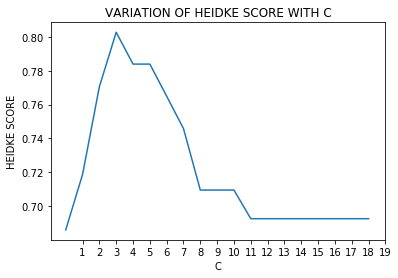

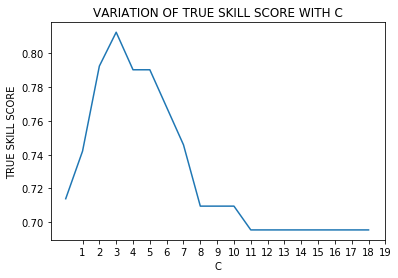

In [19]:
confMatVariation = np.zeros((19,4))
HSSVariation = np.zeros((19,1)) #Store the Heidke Score
TSSVariation = np.zeros((19,1)) #Store the Threat Score

for c in range(1, 20):
    confMat = evaluateSVC(c)
    confMatVariation[c-1]=confMat.ravel()
    HSSVariation[c-1] = findHeidkeScore(confMat)
    TSSVariation[c-1] = findThreatScore(confMat)

print('TN ','FP ','FN ','TP')
print(confMatVariation)
print(HSSVariation)
print(TSSVariation)
# Plot Heidke Score Variation with C
plt.figure()
plt.plot(HSSVariation)
plt.xlabel('C')
plt.ylabel('HEIDKE SCORE')
plt.title('VARIATION OF HEIDKE SCORE WITH C')
plt.xticks(np.arange(1, 20, 1.0))
plt.show()

# Plot Threat Score Variation with C
plt.figure()
plt.plot(TSSVariation)
plt.xlabel('C')
plt.ylabel('TRUE SKILL SCORE')
plt.title('VARIATION OF TRUE SKILL SCORE WITH C')
plt.xticks(np.arange(1, 20, 1.0))
plt.show()

### Evaluating SVC with C = 4 , Optimized from Above Exercise

In [20]:
confMatSVCResamplePCA = evaluateSVC(4)

## Results of SVC on the Dataset

In [21]:
dfResultSVC = {1: ["SVC Results","HSS","TSS"],
               2:["Original Data Set",round(findHeidkeScore(confMatSVCOriginal),3),round(findThreatScore(confMatSVCOriginal),3)],
               3:["Resampled Dataset",round(findHeidkeScore(confMatSVCResample),3),round(findThreatScore(confMatSVCResample),3)],
               4: ["Original Dataset with PCA",round(findHeidkeScore(confMatSVCOriginalPCA),3),round(findThreatScore(confMatSVCOriginalPCA),3)],
               5: ["Resampled Dataset with PCA",round(findHeidkeScore(confMatSVCResamplePCA),3),round(findThreatScore(confMatSVCResamplePCA),3)],
               6: ["Perfect Score",1.000,1.000]
              }

#print(dfResultSVC.items())
for k, v in dfResultSVC.items():
    c1,c2,c3 = v
    print ("{:<30} {:<15} {:<10}".format(c1, c2, c3))




#print('HSS - SVC on Original Dataset:',findHeidkeScore(confMatSVCOriginal),'TSS - SVC on Origianl Dataset:',findThreatScore(confMatSVCOriginal))
#print('HSS - SVC on Resampled Dataset:',findHeidkeScore(confMatSVCResample),'TSS - SVC on Resampled Dataset:',findThreatScore(confMatSVCResample))
#print('HSS - SVC on Original Dataset with PCA:',findHeidkeScore(confMatSVCOriginalPCA),'TSS - SVC on Original Dataset with PCA:',findThreatScore(confMatSVCOriginalPCA))
#print('HSS - SVC on Resampled Dataset with PCA:',findHeidkeScore(confMatSVCResamplePCA),'TSS - SVC on Resampled Dataset with PCA:',findThreatScore(confMatSVCResamplePCA))

SVC Results                    HSS             TSS       
Original Data Set              0.869           0.844     
Resampled Dataset              0.926           0.911     
Original Dataset with PCA      0.888           0.867     
Resampled Dataset with PCA     0.803           0.813     
Perfect Score                  1.0             1.0       


# Using RFC and Evaluating the Effect of Depth on the Classifier

TN  FP  FN  TP
[[26. 19. 15. 56.]
 [30. 15. 18. 53.]
 [36.  9. 18. 53.]
 [38.  7. 18. 53.]
 [38.  7. 19. 52.]
 [40.  5. 18. 53.]
 [40.  5. 20. 51.]
 [39.  6. 19. 52.]
 [39.  6. 20. 51.]
 [40.  5. 21. 50.]
 [40.  5. 21. 50.]
 [39.  6. 21. 50.]
 [40.  5. 21. 50.]
 [40.  5. 21. 50.]
 [40.  5. 21. 50.]
 [40.  5. 21. 50.]
 [40.  5. 21. 50.]
 [40.  5. 21. 50.]
 [40.  5. 21. 50.]]
[[0.37257397]
 [0.40816327]
 [0.52717391]
 [0.56560815]
 [0.54998508]
 [0.60344828]
 [0.57227139]
 [0.56896552]
 [0.55344981]
 [0.55686159]
 [0.55686159]
 [0.5380531 ]
 [0.55686159]
 [0.55686159]
 [0.55686159]
 [0.55686159]
 [0.55686159]
 [0.55686159]
 [0.55686159]]
[[0.36651017]
 [0.41314554]
 [0.54647887]
 [0.59092332]
 [0.57683881]
 [0.63536776]
 [0.60719875]
 [0.59906103]
 [0.58497653]
 [0.59311424]
 [0.59311424]
 [0.57089202]
 [0.59311424]
 [0.59311424]
 [0.59311424]
 [0.59311424]
 [0.59311424]
 [0.59311424]
 [0.59311424]]


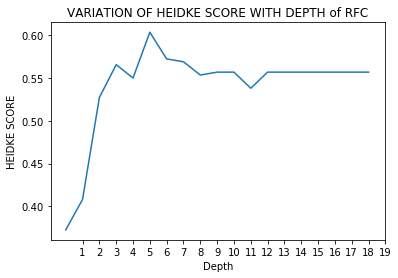

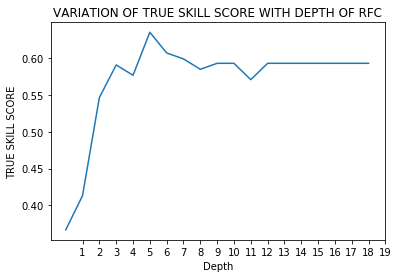

In [22]:
from sklearn.ensemble import RandomForestClassifier

def evaluateRFC(depth):
    modelRFC = RandomForestClassifier(max_depth=depth, random_state=0)
    modelRFC.fit(input_train_res_PCA,output_train_res)
    predictRFCResamplePCA = modelRFC.predict(input_test_PCA)
    confMatRFCResamplePCA = confusion_matrix(output_test,predictRFCResamplePCA)
    return confMatRFCResamplePCA

confMatVariationRFC = np.zeros((19,4))
HSSVariationRFC = np.zeros((19,1)) #Store the Heidke Score
TSSVariationRFC = np.zeros((19,1)) #Store the Threat Score

for depth in range(1, 20):
    confMat = evaluateRFC(depth)
    confMatVariationRFC[depth-1]=confMat.ravel()
    HSSVariationRFC[depth-1] = findHeidkeScore(confMat)
    TSSVariationRFC[depth-1] = findThreatScore(confMat)

print('TN ','FP ','FN ','TP')
print(confMatVariationRFC)
print(HSSVariationRFC)
print(TSSVariationRFC)                   
    
# Plot Heidke Score Variation with C
plt.figure()
plt.plot(HSSVariationRFC)
plt.xlabel('Depth')
plt.ylabel('HEIDKE SCORE')
plt.title('VARIATION OF HEIDKE SCORE WITH DEPTH of RFC')
plt.xticks(np.arange(1, 20, 1.0))
plt.show()

# Plot Threat Score Variation with C
plt.figure()
plt.plot(TSSVariationRFC)
plt.xlabel('Depth')
plt.ylabel('TRUE SKILL SCORE')
plt.title('VARIATION OF TRUE SKILL SCORE WITH DEPTH OF RFC')
plt.xticks(np.arange(1, 20, 1.0))
plt.show()

#print ("\naccuracy_score :",accuracy_score(output_test,predictRFCResamplePCA))
#print('HSS - RFC on Resampled Dataset with PCA:',findHeidkeScore(confMatRFCResamplePCA),
#      'TSS - RFC on Resampled Dataset with PCA:',findThreatScore(confMatRFCResamplePCA))



In [23]:
confMatRFC = evaluateRFC(6)
dfResultRFC = {1: ["RFC Results","HSS","TSS"],
               2: ["Resampled Dataset with PCA",round(findHeidkeScore(confMatRFC),3),round(findThreatScore(confMatRFC),3)],
               3: ["Perfect Score",1.000,1.000]
              }

#print(dfResultSVC.items())
for k, v in dfResultRFC.items():
    c1,c2,c3 = v
    print ("{:<30} {:<15} {:<10}".format(c1, c2, c3))

RFC Results                    HSS             TSS       
Resampled Dataset with PCA     0.603           0.635     
Perfect Score                  1.0             1.0       


# Using NN

In [24]:
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
#import tensorboard
#from tensorboard.callbacks import TensorBoard
import time
NAME = "ionoSphere_data-{}".format(int(time.time()))

tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))



labels = df[34]
inputs = df.drop([34],axis=1)
print('Input Data Shape:',inputs.shape)

pca = PCA() 
inputs = pca.fit_transform(inputs)
total=sum(pca.explained_variance_)

k=0
current_variance=0
while current_variance/total < 0.90:
    current_variance += pca.explained_variance_[k]
    k=k+1


pca = PCA(n_components=k) #Performing PCA
inputs = pca.fit_transform(inputs)
print('Input Data Shape after PCA:',inputs.shape)

inputTrainTest, inputVal, outputTrainTest, outputVal = train_test_split(inputs, 
                                                                      labels, test_size=0.2, 
                                                                      random_state=42) #Val to be used for cross validation

sm = SMOTE(random_state = 42, sampling_strategy = 1.0) #Performing Resampling of Train-Test DataSet
inputTrainTestRes, outputTrainTestRes = sm.fit_sample(inputTrainTest, outputTrainTest.ravel())


inputTrainRes, inputTestRes, outputTrainRes, outputTestRes = train_test_split(inputTrainTestRes,outputTrainTestRes, test_size=0.33, random_state=42)


modelNN = keras.Sequential()
modelNN.add(keras.layers.Dense(18,input_dim=18,activation='relu'))
modelNN.add(keras.layers.Dense(9,activation='relu'))
modelNN.add(keras.layers.Dense(1,activation='sigmoid'))
print(modelNN.summary())
modelNN.compile(loss='binary_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])

histNN = modelNN.fit(inputTrainRes, outputTrainRes,
                     epochs=40,batch_size=1,
                     validation_data=(inputTestRes,outputTestRes),
                     verbose=2
                     #callbacks = [tensorboard]
                    )


Input Data Shape: (351, 34)
Input Data Shape after PCA: (351, 18)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 18)                342       
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 171       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 10        
Total params: 523
Trainable params: 523
Non-trainable params: 0
_________________________________________________________________
None
Train on 243 samples, validate on 121 samples
Epoch 1/40
243/243 - 2s - loss: 0.6726 - accuracy: 0.6543 - val_loss: 0.6331 - val_accuracy: 0.7107
Epoch 2/40
243/243 - 1s - loss: 0.5839 - accuracy: 0.7613 - val_loss: 0.5139 - val_accuracy: 0.7355
Epoch 3/40
243/243 - 1s - loss: 0.4778 - accuracy: 0.8189 - val_loss: 0

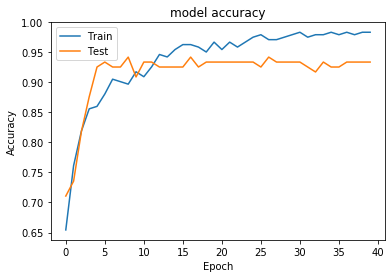

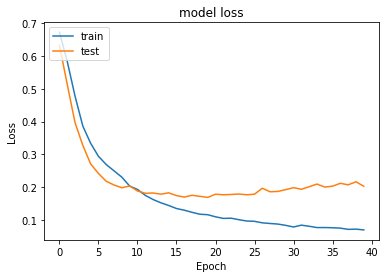

In [25]:
# Summarize history for accuracy
plt.figure()
plt.plot(histNN.history['accuracy'])
plt.plot(histNN.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# summarize history for loss
plt.figure()
plt.plot(histNN.history['loss'])
plt.plot(histNN.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [26]:
predictions = modelNN.predict_classes(inputVal, verbose = 2)
confMatNNResamplePCA = confusion_matrix(outputVal,predictions)

dfResultNN = {1: ["NN Results","HSS","TSS"],
              2: ["Resampled Dataset with PCA",round(findHeidkeScore(confMatNNResamplePCA),3),round(findThreatScore(confMatNNResamplePCA),3)],
              3: ["Perfect Score",1.000,1.000]
              }

for k, v in dfResultNN.items():
    c1,c2,c3 = v
    print ("{:<30} {:<15} {:<10}".format(c1, c2, c3))
#print(confMatNNResamplePCA)
#print ("\naccuracy_score :",accuracy_score(output_test,predictRFCResamplePCA))
#print('HSS - NN on Resampled Dataset with PCA:',findHeidkeScore(confMatNNResamplePCA),
#      'TSS - NN on Resampled Dataset with PCA:',findThreatScore(confMatNNResamplePCA))

71/1 - 0s
NN Results                     HSS             TSS       
Resampled Dataset with PCA     0.848           0.821     
Perfect Score                  1.0             1.0       


# Tally of All Results - FINAL RESULTS

In [27]:
dfResultsAll = {1: ["Comparison of Results","HSS","TSS"],
                2: ["SVC ",round(findHeidkeScore(confMatSVCResamplePCA),3),round(findThreatScore(confMatSVCResamplePCA),3)],
                3: ["RFC ",round(findHeidkeScore(confMatRFC),3),round(findThreatScore(confMatRFC),3)],
                4: ["NN ",round(findHeidkeScore(confMatNNResamplePCA),3),round(findThreatScore(confMatNNResamplePCA),3)],
                5: ["Perfect Score",1.000,1.000]
              }

for k, v in dfResultsAll.items():
    c1,c2,c3 = v
    print ("{:<30} {:<15} {:<10}".format(c1, c2, c3))

Comparison of Results          HSS             TSS       
SVC                            0.803           0.813     
RFC                            0.603           0.635     
NN                             0.848           0.821     
Perfect Score                  1.0             1.0       


# Pl. Ignore below mentioned codes


## Trying with Linear Model: SGD Classifier

/Users/Pramit/opt/miniconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/Pramit/opt/miniconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/Pramit/opt/miniconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/Pramit/opt/miniconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before conv

TN  FP  FN  TP
[[18. 27. 41. 30.]
 [30. 15. 31. 40.]
 [29. 16. 41. 30.]
 [33. 12. 35. 36.]
 [27. 18. 37. 34.]
 [21. 24. 41. 30.]
 [24. 21. 38. 33.]
 [29. 16. 32. 39.]
 [32. 13. 26. 45.]
 [21. 24. 45. 26.]
 [25. 20. 26. 45.]
 [34. 11. 54. 17.]
 [27. 18. 35. 36.]
 [20. 25. 30. 41.]
 [30. 15. 43. 28.]
 [32. 13. 32. 39.]
 [32. 13. 30. 41.]
 [26. 19. 28. 43.]
 [29. 16. 26. 45.]
 [27. 18. 24. 47.]
 [25. 20. 47. 24.]
 [26. 19. 31. 40.]
 [21. 24. 34. 37.]
 [33. 12. 30. 41.]
 [21. 24. 32. 39.]]
[[-0.1679005 ]
 [ 0.21598589]
 [ 0.06079545]
 [ 0.21980538]
 [ 0.07321325]
 [-0.10362998]
 [-0.00175644]
 [ 0.18189833]
 [ 0.32758621]
 [-0.15397924]
 [ 0.18484571]
 [-0.00426212]
 [ 0.1001171 ]
 [ 0.02147239]
 [ 0.05479067]
 [ 0.24171993]
 [ 0.26990632]
 [ 0.17693237]
 [ 0.26736842]
 [ 0.25572869]
 [-0.09588268]
 [ 0.13458669]
 [-0.01172932]
 [ 0.2895888 ]
 [ 0.01545923]]
[[-0.17746479]
 [ 0.23004695]
 [ 0.06697966]
 [ 0.24037559]
 [ 0.07887324]
 [-0.11079812]
 [-0.00187793]
 [ 0.19374022]
 [ 0.34491393

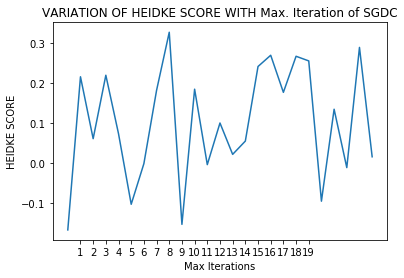

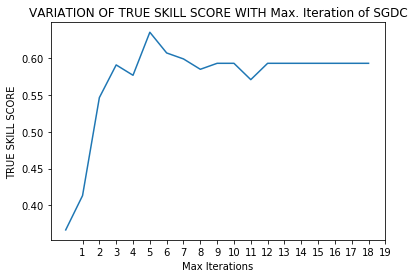

In [28]:
from sklearn.linear_model import SGDClassifier

def evaluateSGDC(maxIter):
    modelSGDC = SGDClassifier(loss="hinge", penalty="l2", max_iter=maxIter)
    modelSGDC.fit(input_train_res_PCA,output_train_res)
    predictSGDCResamplePCA = modelSGDC.predict(input_test_PCA)
    confMatSGDCResamplePCA = confusion_matrix(output_test,predictSGDCResamplePCA)
    return confMatSGDCResamplePCA

confMatVariationSGDC = np.zeros((25,4))
HSSVariationSGDC = np.zeros((25,1)) #Store the Heidke Score
TSSVariationSGDC = np.zeros((25,1)) #Store the Threat Score

for maxIter in range(5, 30):
    confMat = evaluateSGDC(maxIter)
    confMatVariationSGDC[maxIter-5]=confMat.ravel()
    HSSVariationSGDC[maxIter-5] = findHeidkeScore(confMat)
    TSSVariationSGDC[maxIter-5] = findThreatScore(confMat)

print('TN ','FP ','FN ','TP')
print(confMatVariationSGDC)
print(HSSVariationSGDC)
print(TSSVariationSGDC)                   
    
# Plot Heidke Score Variation with C
plt.figure()
plt.plot(HSSVariationSGDC)
plt.xlabel('Max Iterations')
plt.ylabel('HEIDKE SCORE')
plt.title('VARIATION OF HEIDKE SCORE WITH Max. Iteration of SGDC')
plt.xticks(np.arange(1, 20, 1.0))
plt.show()

# Plot Threat Score Variation with C
plt.figure()
plt.plot(TSSVariationRFC)
plt.xlabel('Max Iterations')
plt.ylabel('TRUE SKILL SCORE')
plt.title('VARIATION OF TRUE SKILL SCORE WITH Max. Iteration of SGDC')
plt.xticks(np.arange(1, 20, 1.0))
plt.show()

In [ ]:
SVC_HSS = 2.*((TP*TN) - (FN*FP))/((TP + FN)*(FN + TN) + (TP + FP)*(FP + TN)) # Heidke Skill Score
TSS = (TP/(TP + FN)) - (FP/(FP + TN)) # True Skill Score
BIAS = (TP + FP)/(TP + FN) # Bias of Detection
POD = TP/(TP + FN) # Probability of Detection
POFD = FP/(TN + FP) # Probablity of False Detection
FAR = FP/(TP + FP) # False Alarm Ratio
TS = TP/(TP + FN + FP) # Threat Score
OR = (TP*TN)/(FN*FP) # Odds Ratio

In [ ]:
accuracies = cross_val_score(estimator = model, X = input_train, y = output_train, cv = 5, n_jobs = -1)
mean = accuracies.mean()
variance = accuracies.std()
print("Accuracy mean: "+ str(mean))
print("Accuracy variance: "+ str(variance))

# Accuracy
print ("\naccuracy_score :",accuracy_score(output_test, predictions))

In [ ]:
svc_conf = confusion_matrix(output_test,predictions)

In [ ]:
print(svc_conf)